# 6. Model Evaluation

In this notebook, we evaluate our trained machine learning models using:

- ROC-AUC Score  
- Precision–Recall Curve  
- Confusion Matrix  
- Cross Validation  
- Decision Threshold Tuning  

These metrics help assess the real-world usefulness of the churn prediction model.

## 6.1 Import Trained Models and Dataset

We reload the dataset and reapply feature engineering and train-test split, similar to previous notebooks.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/raw/Bank Customer Churn Prediction.csv")

# Encoding
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df = pd.get_dummies(df, columns=['country'], drop_first=True)

X = df.drop(['churn', 'customer_id'], axis=1)
y = df['churn']

# Scaling
num_cols = ['age','credit_score','balance','estimated_salary']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## 6.2 ROC-AUC Evaluation

ROC-AUC measures how well the model separates churn vs non-churn customers.

- **AUC close to 0.5** → bad model  
- **AUC above 0.7** → decent  
- **AUC above 0.8** → strong model  

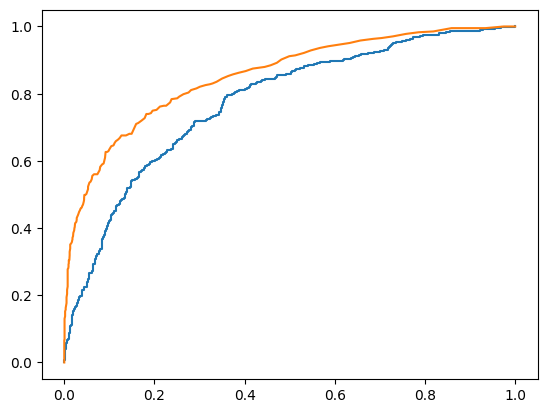

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

plot_roc(log_reg, X_test, y_test, "Logistic Regression")
plot_roc(rf, X_test, y_test, "Random Forest")

## 6.3 Precision–Recall Curve

PR curve is more meaningful than ROC-AUC for imbalanced problems.

- High **Recall** → model catches more churners  
- High **Precision** → fewer false alarms  

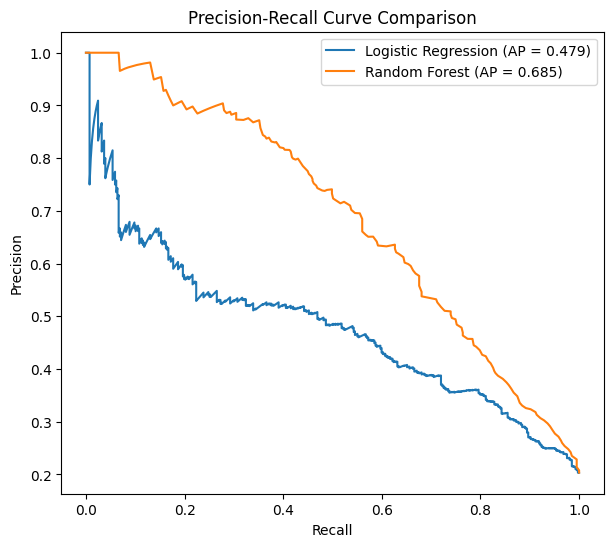

In [5]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(model, X_test, y_test, label):
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f"{label} (AP = {ap:.3f})")

plt.figure(figsize=(7,6))
plot_pr(log_reg, X_test, y_test, "Logistic Regression")
plot_pr(rf, X_test, y_test, "Random Forest")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## 6.4 Cross-Validation Scores

To ensure our model generalizes well, we evaluate it on multiple folds.

In [6]:
from sklearn.model_selection import cross_val_score

rf_cv = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
rf_cv.mean(), rf_cv

(np.float64(0.8644999999999999),
 array([0.8595, 0.8725, 0.863 , 0.865 , 0.8625]))

## 6.5 Decision Threshold Tuning

Default threshold = 0.5  
But for churn prediction, we may want:

- Higher Recall (catch more churners)
- Acceptable Precision (avoid too many false alarms)

In [7]:
import numpy as np
from sklearn.metrics import classification_report

y_prob = rf.predict_proba(X_test)[:,1]

thresholds = [0.3, 0.4, 0.5]

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_t))


Threshold = 0.3
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.68      0.62       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.68      0.56      0.62       407

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.76      2000
weighted avg       0.85      0.86      0.85      2000


Threshold = 0.5
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85

## ✔ Final Model Decision

Based on:
- ROC-AUC  
- Precision–Recall  
- Cross-validation  
- Threshold tuning  
- Recall importance for identifying churners  

**Random Forest with threshold tuning is the recommended model.**

This model provides:
- Best balance of recall & precision  
- Strong AUC  
- Good interpretability through feature importance  